## Data preparation

For tuning the ML models and augmentation parameters, we need to split the train set into a train set and validation set. If we were to use temporal info later, we need to separate storms instead of images.



In [1]:
from separate_val_data import separate_val_files 

In [2]:
train_dir = 'data/train'
val_dir = 'data/val' 
# val dictionary should not exist, otherwise, it would raise error to avoid runnig it multiple times.
val_fr = 0.2

separate_val_files(train_dir, val_dir, val_fr)

ValueError: data/val already exist.

## Directory structure

```
project
|____data
|    |____train
|    |     |___abc_001.jpg
|    |     |___abc_002.jpg
|    |
|    |____val
|    |     |___acc_001.jpg
|    |     |___acc_002.jpg
|    |
|    |____training_set_features.csv
|    |____training_set_labels.csv
|____separate_val_data.py
|____image_batch_gen.py
|____Hurricane.ipynb
```

## Make batch

In [11]:
import os
from os.path import join
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [12]:
class ImgBatchGen(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ground_truth_file, batch_size=32, img_size=None):
        self.bacth_size = batch_size
        files = os.listdir(img_dir)
        label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]
        random.shuffle(self.files)
        self.img_size=img_size
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images, labels = [], []

        for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
            img = cv2.imread(file, 0)
            if img is None:
                continue
            if self.img_size is not None:
                img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
            images.append(img)
            labels.append(label)

        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels).astype(np.float32)

        return x, y
    

In [28]:
class ImgBatchGenOneShot(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ground_truth_file, batch_size=32, img_size=None):
        self.bacth_size = batch_size
        self.img_size=img_size
        files = os.listdir(img_dir)
        label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]
        random.shuffle(self.files)
        
        images, labels = [], []
        for file, label in self.files:
            img = cv2.imread(file, 0)
            if img is None:
                continue
            if self.img_size is not None:
                img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
            images.append(img)
            labels.append(label)
        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels).astype(np.float32)
            
        self.x = x
        self.y = y
        print('x shape', self.x.shape)
        print('y shape', self.y.shape)
        
        #
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images, labels = [], []
        
        x_batch = self.x[index*self.bacth_size:(index+1)*self.bacth_size, :, :]
        y_batch = self.y[index*self.bacth_size:(index+1)*self.bacth_size]

#         for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
#             img = cv2.imread(file, 0)
#             if img is None:
#                 continue
#             if self.img_size is not None:
#                 img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
#             images.append(img)
#             labels.append(label)

#         x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
#         y = np.array(labels).astype(np.float32)

        return x_batch, y_batch

In [29]:
img_size = 64
train_batchgen = ImgBatchGenOneShot('data/train', 'data/training_set_labels.csv', 32, img_size=img_size)
val_batchgen = ImgBatchGenOneShot('data/val', 'data/training_set_labels.csv', 32, img_size=img_size)

x shape (56739, 64, 64, 1)
y shape (56739,)
x shape (13518, 64, 64, 1)
y shape (13518,)


(32, 64, 64, 1) (32,)
30.0


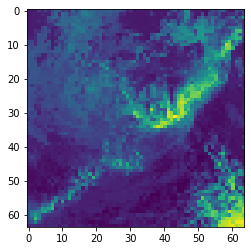

In [30]:
train_x, train_y = train_batchgen[0]
print(train_x.shape, train_y.shape)
plt.imshow(train_x[2])
print(train_y[2])

## Make Model

In [31]:
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

In [36]:
model = Sequential()
model.add(Conv2D(64, (7,7), padding='same', activation='relu', input_shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [37]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 64, 64, 64)        3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)       

In [38]:
## Train

In [ ]:
history = model.fit(train_batchgen, epochs = 100, verbose=1, validation_data=val_batchgen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1773 steps, validate for 422 steps
Epoch 1/100
1773/1773 [==============================] - 33s 19ms/step - loss: 292.3678 - mse: 292.3680 - mae: 12.0372 - mape: 25.6826 - val_loss: 214.7983 - val_mse: 214.7984 - val_mae: 10.7574 - val_mape: 23.5780
Epoch 2/100
1773/1773 [==============================] - 32s 18ms/step - loss: 126.5352 - mse: 126.5351 - mae: 8.3574 - mape: 18.2532 - val_loss: 161.8723 - val_mse: 161.8722 - val_mae: 9.4758 - val_mape: 21.8896
Epoch 3/100
1773/1773 [==============================] - 31s 18ms/step - loss: 84.0195 - mse: 84.0195 - mae: 6.8961 - mape: 15.2016 - val_loss: 145.2936 - val_mse: 145.2936 - val_mae: 8.9366 - val_mape: 21.3579
Epoch 4/100
1773/1773 [==============================] - 30s 17ms/step - loss: 59.0595 - mse: 59.0595 - mae: 5.8114 - mape: 12.8342 - val_loss: 142.7691 - val_mse: 142.7690 - val_mae: 8.7832 - val_mape: 19.3103
Epoch 5/100
1773/1773 [==============================] 

In [ ]:
model.save('aug_1')


In [11]:
ground_truth = []
pred = []
i = 0
for x_batch, y_batch in val_batchgen:
    pred.append(model.predict(x_batch).ravel())
    ground_truth.append(y_batch)
pred = np.hstack(pred)
ground_truth = np.hstack(ground_truth)

Text(0, 0.5, 'Prediction')

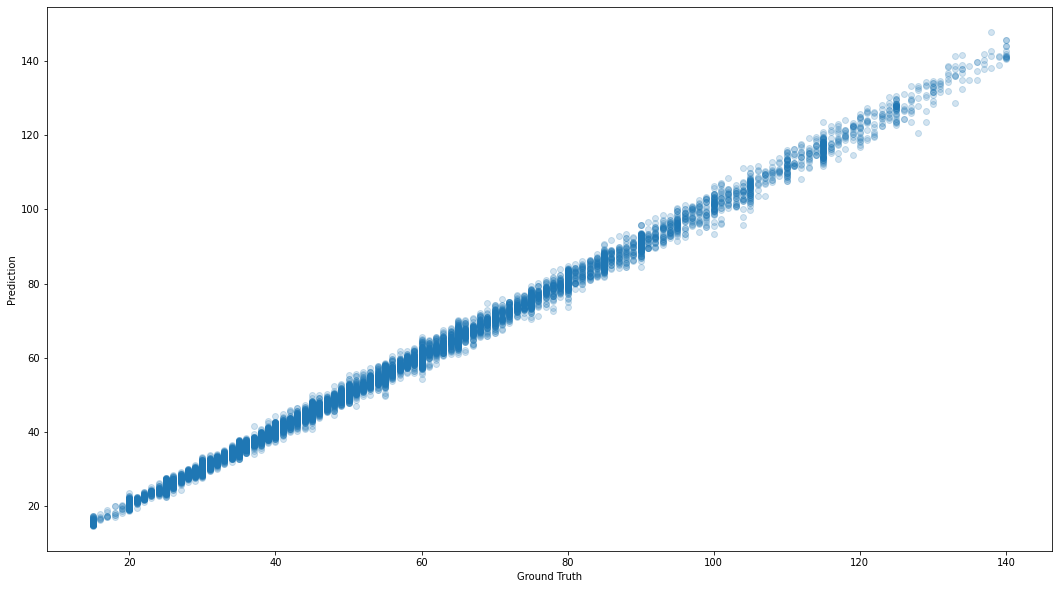

In [26]:
plt.figure(figsize=(18, 10))
plt.scatter(ground_truth, pred, alpha=0.2)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')

In [20]:
import numpy as np

In [21]:
a = np.array(range(1000))

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])